# Challenges local development

This notebook was used for locally developing Python code for the challenges. It also provides some visualizations.

## Setup

### Python environment

Create a Python 3.8 kernel.

In [1]:
# yolo
import warnings

warnings.simplefilter("ignore")

## Installs

In [2]:
#%pip install --upgrade 'snowflake-snowpark-python[pandas]' pyyaml numpy pandas scikit-learn matplotlib seaborn ipympl prophet mlflow 'thefuzz[speedup]' rapidfuzz

## Imports

TODO: move to `requirements.txt`.

In [3]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from datetime import datetime
from sklearn.cluster import KMeans
from prophet.serialize import model_to_json, model_from_json
from snowflake.snowpark import Session
from sklearn.decomposition import PCA

from rapidfuzz.process import extractOne

Importing plotly failed. Interactive plots will not work.


## Connect to Snowpark in Python

In [4]:
# replace as needed
PROFILE_PATH = "/root/.dbt/profiles.yml"
PROFILE_NAME = "snowflake"
PROFILE_OUTPUT = "dev"

# read in dbt profile
with open(PROFILE_PATH, "r") as f:
    profiles = yaml.safe_load(f)
    profile = profiles[PROFILE_NAME]["outputs"][PROFILE_OUTPUT]

# build connection parameters from profile
conn_params = {
    "account": profile["account"],
    "user": profile["user"],
    "role": profile["role"],
    "warehouse": profile["warehouse"],
    "database": profile["database"],
    "schema": profile["schema"],
    "authenticator": profile["authenticator"],
}

In [5]:
schema = conn_params["schema"]

In [6]:
from snowflake.snowpark import Session

s = Session.builder.configs(conn_params).create()
s

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [7]:
s.sql("select current_warehouse(), current_database(), current_schema()").collect()

[Row(CURRENT_WAREHOUSE()='TRANSFORMING', CURRENT_DATABASE()='ANALYTICS', CURRENT_SCHEMA()='DBT_CODY')]

## Challenge 1: describe the data

In [8]:
orders = s.table(f"{schema}.orders").sample(frac=0.1).to_pandas()
orders.head()

,LOCATION_ID,ORDER_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,CUSTOMER_ID_MATCH,CUSTOMER_NAME_MATCH,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,...,COUNT_ITEMS,SUBTOTAL_DRINK_ITEMS,SUBTOTAL_FOOD_ITEMS,SUBTOTAL,ORDER_COST,CUSTOMER_ORDER_INDEX,LOCATION_NAME,IS_FIRST_ORDER,IS_FOOD_ORDER,IS_DRINK_ORDER
0,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,c9d3cb25-7101-4136-9343-79c5f41edc9f,15.60,0.60,2017-11-09 14:57:00,ARY Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.636364,1,...,2,11.0,4.0,15.0,1.84,2,Brooklyn,False,True,True
1,fb199829-e587-4d3e-8de0-efc0156c0d48,b725d16e-cd8d-4bb8-beff-f882dd957dc5,11.68,0.68,2018-05-29 12:00:00,aARON Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,0,...,2,0.0,11.0,11.0,1.45,10,Chicago,False,False,True
2,fb199829-e587-4d3e-8de0-efc0156c0d48,b61036f7-82d5-4dd3-bb23-8fd8d990ec32,11.68,0.68,2018-07-01 13:30:00,Aaron Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,1.000000,1,...,1,11.0,0.0,11.0,1.21,16,Chicago,False,True,False
3,fb199829-e587-4d3e-8de0-efc0156c0d48,bd0181af-ac5f-47b5-85b6-347cadc05687,23.37,1.37,2018-11-20 14:13:00,AARON Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.636364,2,...,2,22.0,0.0,22.0,3.72,44,Chicago,False,True,False
4,fb199829-e587-4d3e-8de0-efc0156c0d48,552f2552-7f53-4e94-8b93-1112c3f29ee8,11.68,0.68,2018-11-30 15:40:00,ARON llis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,1,...,1,11.0,0.0,11.0,1.21,47,Chicago,False,True,False


In [9]:
described = orders.describe()
described.head()

,ORDER_TOTAL,TAX_PAID,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,COUNT_DRINK_ITEMS,COUNT_ITEMS,SUBTOTAL_DRINK_ITEMS,SUBTOTAL_FOOD_ITEMS,SUBTOTAL,ORDER_COST,CUSTOMER_ORDER_INDEX
count,180765.000000,180765.000000,108713.000000,180765.000000,180765.000000,180765.000000,180765.000000,180765.000000,180765.000000,180765.000000,180765.000000
mean,13.044423,0.678407,0.703286,0.484911,1.167759,1.652671,5.823694,6.541764,12.365458,2.580312,143935.914054
std,12.433870,0.688038,0.159791,0.839885,0.607963,1.194112,10.115988,3.581993,11.782537,2.653937,220049.339660
min,4.160000,0.160000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.630000,1.000000
25%,6.240000,0.250000,0.571429,0.000000,1.000000,1.000000,0.000000,5.000000,6.000000,0.820000,177.000000


## Challenge 2: pivot the data

In [10]:
order_items = s.table(f"{schema}.stg_order_items").sample(frac=0.1).to_pandas()
order_items.head()

,ORDER_ITEM_ID,ORDER_ID,PRODUCT_ID
0,40577572-aa22-4e64-9b5f-a3835d8eefa5,34ac0c30-9309-4d72-aabf-567a3faf1fa2,JAF-003
1,4e8160f2-58d6-46a9-adff-a14c50088c07,c8de4547-96d9-42ff-993e-8aa11b2553e8,BEV-002
2,43a716af-1ed8-445f-abf8-9dbe3257d739,c8de4547-96d9-42ff-993e-8aa11b2553e8,JAF-002
3,68105113-54cd-44ca-8b65-0034da02e922,4fa69d7b-854c-4af5-b1b7-3a54fd2b1fbb,JAF-001
4,0062b0a0-c711-4fca-8e03-bde0840fbf2d,ad904ad9-b971-486b-9ba9-e2e9596d17b6,BEV-005


In [11]:
products = s.table(f"{schema}.stg_products").to_pandas()
products

,PRODUCT_ID,PRODUCT_NAME,PRODUCT_TYPE,PRODUCT_DESCRIPTION,PRODUCT_PRICE,IS_FOOD_ITEM,IS_DRINK_ITEM
0,JAF-001,nutellaphone who dis?,jaffle,nutella and banana jaffle,11.0,1,0
1,JAF-002,doctor stew,jaffle,house-made beef stew jaffle,11.0,1,0
2,JAF-003,the krautback,jaffle,lamb and pork bratwurst with house-pickled cab...,12.0,1,0
3,JAF-004,flame impala,jaffle,pulled pork and pineapple al pastor marinated ...,14.0,1,0
4,JAF-005,mel-bun,jaffle,"melon and minced beef bao, in a jaffle, savory...",12.0,1,0
5,BEV-001,tangaroo,beverage,mango and tangerine smoothie,6.0,0,1
6,BEV-002,chai and mighty,beverage,oatmilk chai latte with protein boost,5.0,0,1
7,BEV-003,vanilla ice,beverage,iced coffee with house-made french vanilla syrup,6.0,0,1
8,BEV-004,for richer or pourover,beverage,daily selection of single estate beans for a d...,7.0,0,1
9,BEV-005,adele-ade,beverage,"a kiwi and lime agua fresca, hello from the ot...",4.0,0,1


In [12]:
product_ids = sorted(list(set(products["product_id".upper()].unique())))
product_ids

['BEV-001',
 'BEV-002',
 'BEV-003',
 'BEV-004',
 'BEV-005',
 'JAF-001',
 'JAF-002',
 'JAF-003',
 'JAF-004',
 'JAF-005']

In [13]:
order_item_product_subtotals = (
    order_items.merge(products, on="product_id".upper())
    .groupby(
        ["order_id".upper(), "product_id".upper()],
        as_index=False,
    )
    .agg(SUBTOTAL=("product_price".upper(), "sum"))
    .reset_index()
    .pivot(
        index="order_id".upper(),
        columns="product_id".upper(),
        values="subtotal".upper(),
    )
    .reset_index()
)
order_item_product_subtotals.head()

PRODUCT_ID,ORDER_ID,BEV-001,BEV-002,BEV-003,BEV-004,BEV-005,JAF-001,JAF-002,JAF-003,JAF-004,JAF-005
0,00002536-f77a-4a7f-8f24-2bb48553d7a9,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1,00002fe4-6e8e-441e-9b0e-cdcb19bbd5e8,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000545d-680a-4996-9f24-014f97aa0feb,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
3,00008372-69f1-422f-8bac-3ee9b4ac3719,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00008da9-3189-40a6-b525-6652cac06759,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
renames = {product_id: f"subtotal_{product_id}".upper() for product_id in product_ids}
order_item_product_subtotals = order_item_product_subtotals.rename(columns=renames)
order_item_product_subtotals.head()

PRODUCT_ID,ORDER_ID,SUBTOTAL_BEV-001,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005
0,00002536-f77a-4a7f-8f24-2bb48553d7a9,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1,00002fe4-6e8e-441e-9b0e-cdcb19bbd5e8,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000545d-680a-4996-9f24-014f97aa0feb,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
3,00008372-69f1-422f-8bac-3ee9b4ac3719,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00008da9-3189-40a6-b525-6652cac06759,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
order_item_product_subtotals = order_item_product_subtotals.fillna(0)
order_item_product_subtotals.head()

PRODUCT_ID,ORDER_ID,SUBTOTAL_BEV-001,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005
0,00002536-f77a-4a7f-8f24-2bb48553d7a9,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
1,00002fe4-6e8e-441e-9b0e-cdcb19bbd5e8,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000545d-680a-4996-9f24-014f97aa0feb,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,00008372-69f1-422f-8bac-3ee9b4ac3719,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00008da9-3189-40a6-b525-6652cac06759,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
orders_with_subtotals = orders.merge(
    order_item_product_subtotals, on="order_id".upper()
)
orders_with_subtotals.tail()

,LOCATION_ID,ORDER_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,CUSTOMER_ID_MATCH,CUSTOMER_NAME_MATCH,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,...,SUBTOTAL_BEV-001,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005
27583,fb199829-e587-4d3e-8de0-efc0156c0d48,12a30def-efa1-4741-bae6-6d2c5a83ecb8,18.06,1.06,2021-02-19 11:20:00,Kelly white,69f09628-33f4-4ad0-9867-d13e645721dc,Kelly White,0.909091,1,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27584,fb199829-e587-4d3e-8de0-efc0156c0d48,2e59de27-a211-486a-a16b-32a54d328279,18.06,1.06,2022-03-06 12:17:00,elly hite,69f09628-33f4-4ad0-9867-d13e645721dc,Kelly White,0.818182,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
27585,eed97b42-081b-4ed8-b5e4-32a45659094d,1c98d00f-6b55-4896-b2b7-b89d3c7d5876,22.57,1.57,2018-12-17 13:01:00,rhonda DUNN,c9f35caf-ebaa-44f1-a19c-5b375489fd48,Rhonda Dunn,0.636364,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
27586,eed97b42-081b-4ed8-b5e4-32a45659094d,3f16c643-e108-4b52-88f0-df7c8c66d4f3,21.50,1.50,2019-01-09 16:50:00,Rhonda Dun,c9f35caf-ebaa-44f1-a19c-5b375489fd48,Rhonda Dunn,0.909091,1,...,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0
27587,eed97b42-081b-4ed8-b5e4-32a45659094d,e55b7412-84e0-415a-ab4e-44dac49c4de2,17.20,1.20,2021-05-31 16:30:00,Rhonda DUN,c9f35caf-ebaa-44f1-a19c-5b375489fd48,Rhonda Dunn,0.727273,1,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


## Challenge 3: flag fuzzy duplicates

In [17]:
customers = s.table(f"{schema}.int_customers").to_pandas()
customers.head()

,CUSTOMER_ID,CUSTOMER_NAME
0,15df7af1-ef13-473f-bbea-deedde94ac32,Samuel Stout
1,face746f-5b3a-4299-b3ea-a83c6a3a6712,James Gutierrez
2,e4a57063-7fff-4e07-acec-6c255e491a9b,Judy Alvarez
3,6338ad00-dbf7-419a-9882-be4926d0deff,Vanessa Howell
4,6d28d61c-33c4-4759-85ab-80dcd23e17ec,Alyssa Riddle


In [18]:
# use the earlier int_orders table that has the unmatch customer_names
orders = s.table(f"{schema}.int_orders").sample(n=40).to_pandas()
orders.head()

,ORDER_ID,LOCATION_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME
0,6df110c1-316b-4137-bf83-2d27b5bb3e88,b8d4c6a3-41cd-42aa-857f-3183be9dca08,4.16,0.16,1637397600000000,MARISSA FISCHER
1,0595ad39-5241-47b6-b144-7dc1778c98f1,fb199829-e587-4d3e-8de0-efc0156c0d48,4.25,0.25,1609921620000000,lorraina wAlKeR
2,34976676-ea4d-446e-855d-47742ea22e63,fb199829-e587-4d3e-8de0-efc0156c0d48,6.37,0.37,1654761780000000,Bvidhev ILMORE
3,e87f0611-9cec-45a5-97d7-53cd81f05782,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,4.16,0.16,1535354220000000,Janet martinez
4,d2a67db1-cfc0-4dc9-b42a-e8f9bd4dae1e,fb199829-e587-4d3e-8de0-efc0156c0d48,5.31,0.31,1547384640000000,athan GLASS


In [19]:
unfuzzed = orders
names = sorted(list(customers["customer_name".upper()].unique()))
unfuzzed[["matched_name".upper(), "matched_likelihood".upper()]] = unfuzzed.apply(
    lambda x: extractOne(x["customer_name".upper()], names)[0:2],
    axis=1,
    result_type="expand",
)

unfuzzed.head()

,ORDER_ID,LOCATION_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,MATCHED_NAME,MATCHED_LIKELIHOOD
0,6df110c1-316b-4137-bf83-2d27b5bb3e88,b8d4c6a3-41cd-42aa-857f-3183be9dca08,4.16,0.16,1637397600000000,MARISSA FISCHER,Marissa Fischer,100.000000
1,0595ad39-5241-47b6-b144-7dc1778c98f1,fb199829-e587-4d3e-8de0-efc0156c0d48,4.25,0.25,1609921620000000,lorraina wAlKeR,Lorraine Walker,93.333333
2,34976676-ea4d-446e-855d-47742ea22e63,fb199829-e587-4d3e-8de0-efc0156c0d48,6.37,0.37,1654761780000000,Bvidhev ILMORE,Bridget Gilmore,75.862069
3,e87f0611-9cec-45a5-97d7-53cd81f05782,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,4.16,0.16,1535354220000000,Janet martinez,Janet Martinez,100.000000
4,d2a67db1-cfc0-4dc9-b42a-e8f9bd4dae1e,fb199829-e587-4d3e-8de0-efc0156c0d48,5.31,0.31,1547384640000000,athan GLASS,Nathan Glass,95.652174


## Challenge 4: cluster customers by their order history

In [20]:
X = orders_with_subtotals.select_dtypes(include=["number"]).fillna(0).values
X

array([[43.56    ,  2.56    ,  0.909091, ...,  0.      ,  0.      ,
         0.      ],
       [10.62    ,  0.62    ,  0.818182, ...,  0.      ,  0.      ,
         0.      ],
       [10.62    ,  0.62    ,  0.636364, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [22.57    ,  1.57    ,  0.636364, ...,  0.      , 14.      ,
         0.      ],
       [21.5     ,  1.5     ,  0.909091, ...,  0.      , 14.      ,
         0.      ],
       [17.2     ,  1.2     ,  0.727273, ...,  0.      ,  0.      ,
         0.      ]])

Detour: motivation!

In [21]:
n_components = 3
pca = PCA(n_components=n_components)
pca

PCA(n_components=3)

In [22]:
pca = pca.fit(X)
pca

PCA(n_components=3)

In [23]:
X_pca = pca.transform(X)
X_pca.shape

(27588, 3)

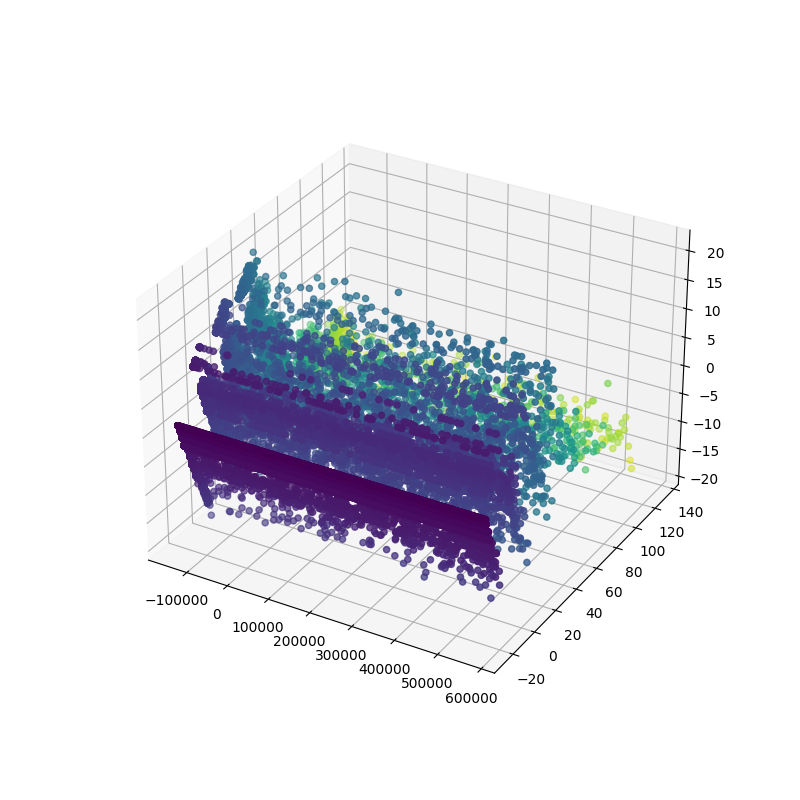

In [24]:
%matplotlib ipympl

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=orders_with_subtotals["subtotal".upper()].values,
)

In [25]:
model = KMeans(n_clusters=5)
model

KMeans(n_clusters=5)

In [26]:
model = model.fit(X)
model

KMeans(n_clusters=5)

In [27]:
cluster_labels = model.predict(X)
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

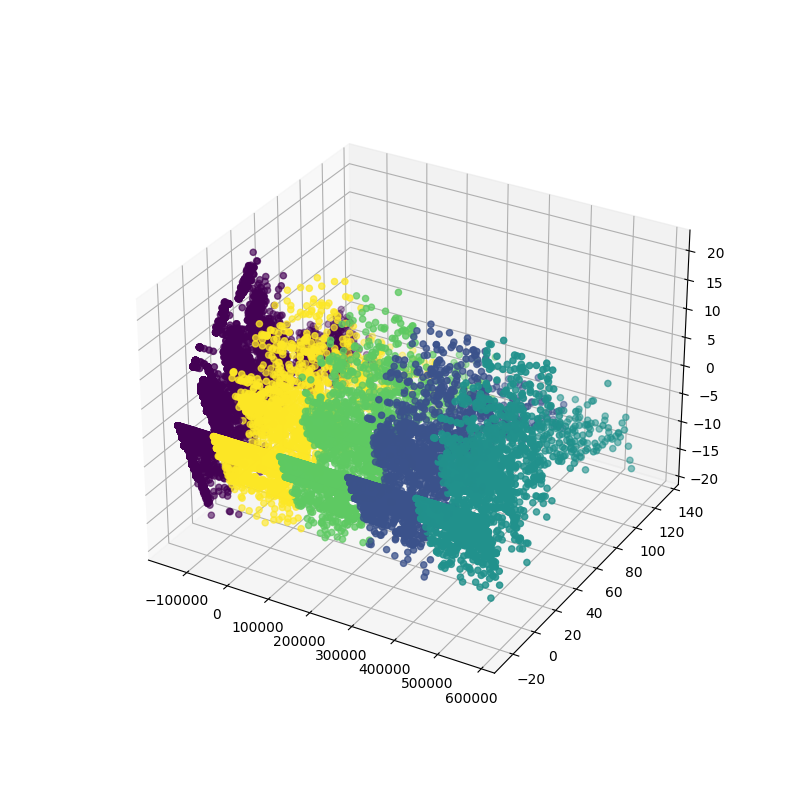

In [28]:
%matplotlib ipympl

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")

ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=cluster_labels,
)

In [29]:
temp = pd.DataFrame(data=cluster_labels, columns=["cluster_label"])
temp

,cluster_label
0,0
1,0
2,0
3,0
4,0
...,...
27583,0
27584,0
27585,0
27586,0


In [30]:
orders_with_subtotals_and_clusters = orders_with_subtotals.merge(
    temp, left_index=True, right_index=True
)
orders_with_subtotals_and_clusters.head()

,LOCATION_ID,ORDER_ID,ORDER_TOTAL,TAX_PAID,ORDERED_AT,CUSTOMER_NAME,CUSTOMER_ID_MATCH,CUSTOMER_NAME_MATCH,MATCH_LIKELIHOOD,COUNT_FOOD_ITEMS,...,SUBTOTAL_BEV-002,SUBTOTAL_BEV-003,SUBTOTAL_BEV-004,SUBTOTAL_BEV-005,SUBTOTAL_JAF-001,SUBTOTAL_JAF-002,SUBTOTAL_JAF-003,SUBTOTAL_JAF-004,SUBTOTAL_JAF-005,cluster_label
0,fb199829-e587-4d3e-8de0-efc0156c0d48,acb96ad1-8020-4fd1-abcd-f049ba0ca15e,43.56,2.56,2018-12-28 09:28:00,Aaro Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.909091,3,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0
1,fb199829-e587-4d3e-8de0-efc0156c0d48,c8c85941-df0f-441b-a586-626ba5a5acf3,10.62,0.62,2019-03-22 11:20:00,aaron ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.818182,0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,fb199829-e587-4d3e-8de0-efc0156c0d48,de8f2876-8f86-4a60-8d1d-03dbdaf191ca,10.62,0.62,2020-01-26 08:43:00,Aaron ELLIS,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.636364,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,fb199829-e587-4d3e-8de0-efc0156c0d48,a6539b96-fb3d-44f6-a98b-08c890f22069,55.25,3.25,2020-06-18 13:46:00,aArOn Ellis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.727273,3,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0
4,fb199829-e587-4d3e-8de0-efc0156c0d48,98a207ac-cedf-4a98-ae61-1c8d5770d1fd,41.43,2.43,2020-10-03 11:19:00,AARON llis,9df84231-f9dc-4305-aa25-110e6f98a84c,Aaron Ellis,0.545455,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0


## Challenge 5: predict revenue by location

In [31]:
revenue = s.table(f"{schema}.revenue_weekly_by_location").to_pandas()
revenue.head()

,DATE_WEEK,LOCATION_NAME,REVENUE
0,2018-03-05,Philadelphia,15535.28
1,2018-03-05,New Orleans,0.00
2,2018-03-05,Chicago,0.00
3,2018-03-05,Brooklyn,23452.94
4,2018-02-26,San Francisco,0.00


In [32]:
renames = {
    "date_week".upper(): "ds",
    "location_name".upper(): "location",
    "revenue".upper(): "y",
}
revenue = revenue.rename(columns=renames)
revenue.head()

,ds,location,y
0,2018-03-05,Philadelphia,15535.28
1,2018-03-05,New Orleans,0.00
2,2018-03-05,Chicago,0.00
3,2018-03-05,Brooklyn,23452.94
4,2018-02-26,San Francisco,0.00


In [33]:
locations = sorted(list(revenue["location"].unique()))
locations

['Brooklyn', 'Chicago', 'New Orleans', 'Philadelphia', 'San Francisco']

In [34]:
models = {
    location: Prophet().fit(revenue[revenue["location"] == location])
    for location in locations
}
models

02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing
02:25:15 - cmdstanpy - INFO - Chain [1] start processing
02:25:15 - cmdstanpy - INFO - Chain [1] done processing


{'Brooklyn': <prophet.forecaster.Prophet at 0x7f0f5bf2e6d0>,
 'Chicago': <prophet.forecaster.Prophet at 0x7f0f5bf2e8e0>,
 'New Orleans': <prophet.forecaster.Prophet at 0x7f0f5bf2e760>,
 'Philadelphia': <prophet.forecaster.Prophet at 0x7f0f5bf2e910>,
 'San Francisco': <prophet.forecaster.Prophet at 0x7f0f5bebe3d0>}

In [35]:
future = models[locations[0]].make_future_dataframe(periods=52 * 3, freq="W")
future.tail()

,ds
470,2025-08-31
471,2025-09-07
472,2025-09-14
473,2025-09-21
474,2025-09-28


In [36]:
forecasts = {location: models[location].predict(future) for location in locations}
forecasts

{'Brooklyn':             ds         trend    yhat_lower    yhat_upper   trend_lower  \
 0   2016-08-29  -4262.555995  -9685.963923  -5632.698513  -4262.555995   
 1   2016-09-05  -3926.619887  -8844.463416  -4816.259397  -3926.619887   
 2   2016-09-12  -3590.683779  -7494.369649  -3299.583827  -3590.683779   
 3   2016-09-19  -3254.747670  -5651.555635  -1603.283096  -3254.747670   
 4   2016-09-26  -2918.811562  -4025.531312    152.510382  -2918.811562   
 ..         ...           ...           ...           ...           ...   
 470 2025-08-31  30015.945553  17850.306347  35439.375714  21334.795399   
 471 2025-09-07  30033.906274  18152.125067  35985.423425  21279.627446   
 472 2025-09-14  30051.866995  19408.763063  37966.269143  21223.571450   
 473 2025-09-21  30069.827716  20956.764277  38924.748681  21151.416428   
 474 2025-09-28  30087.788437  21615.442241  40573.696837  21075.712160   
 
       trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
 0  

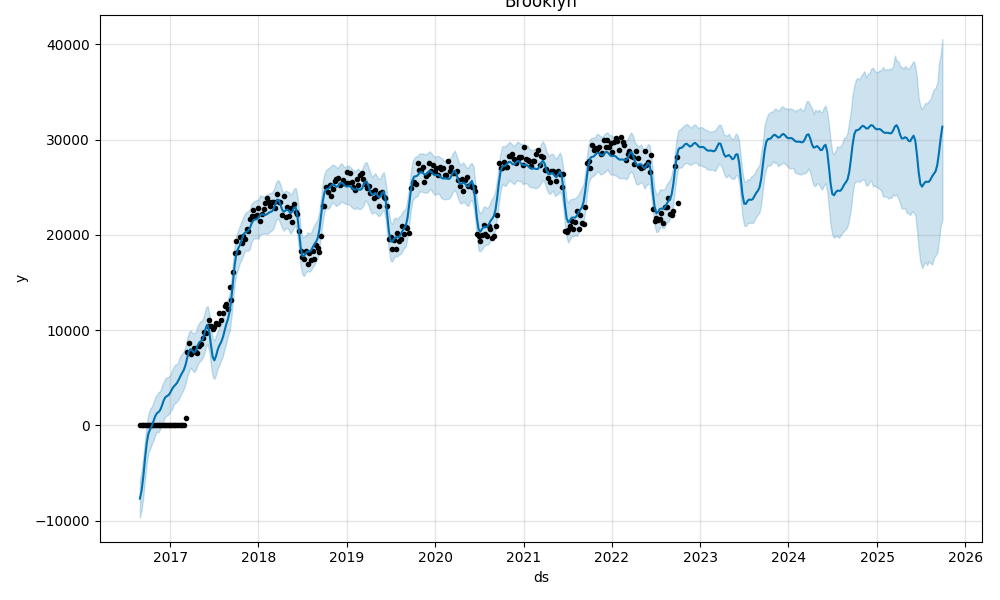

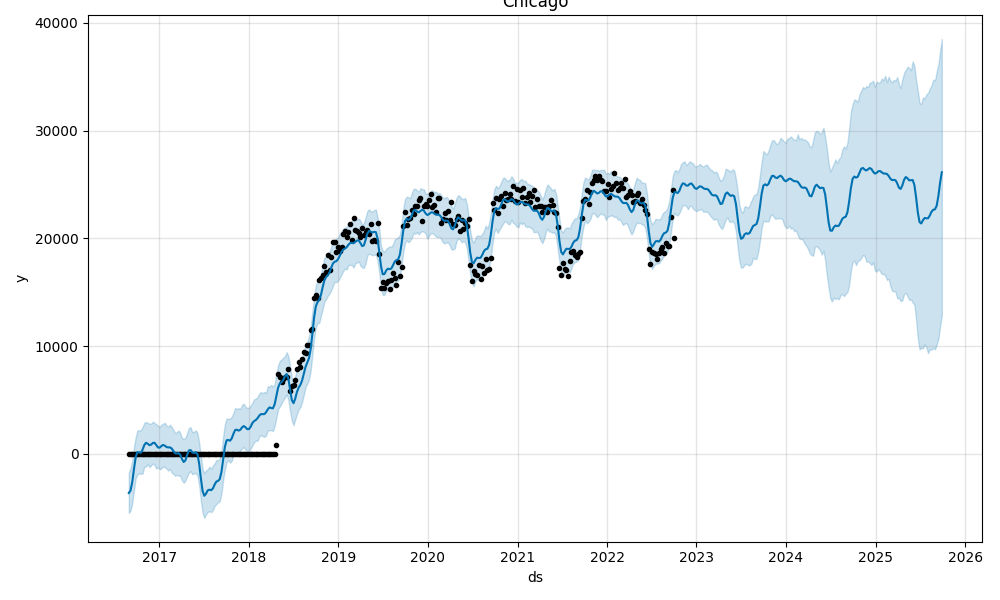

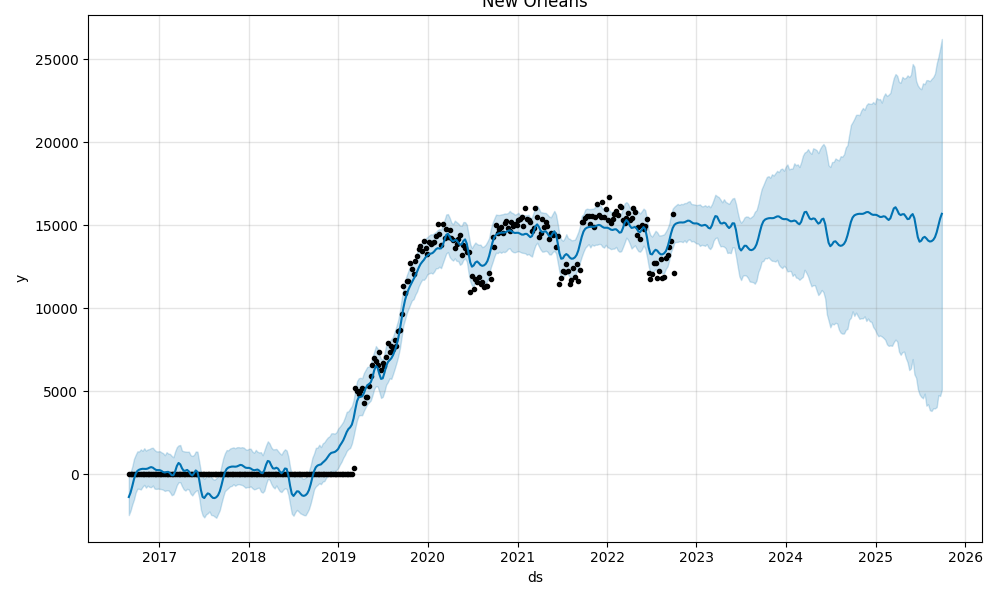

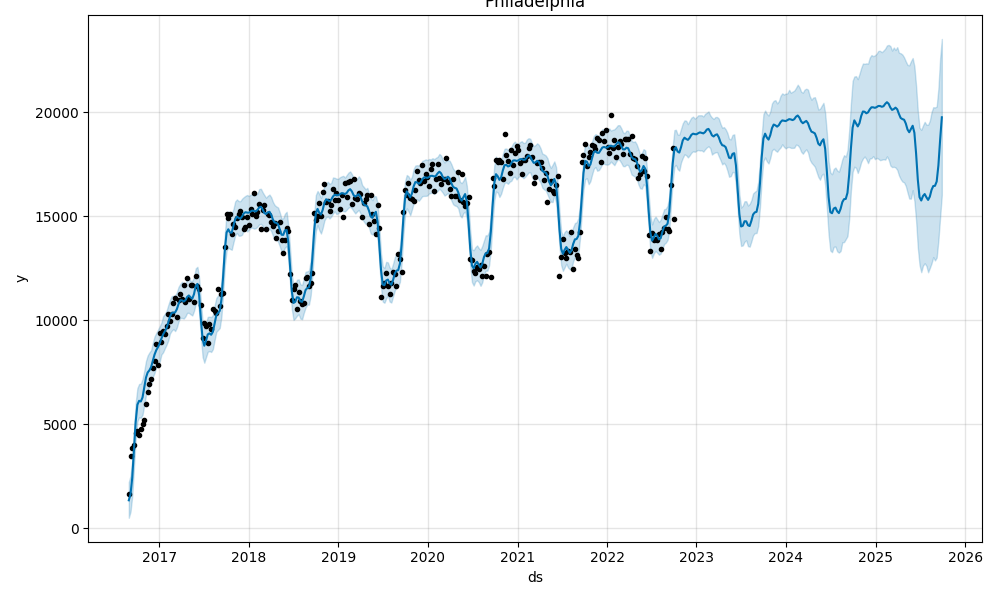

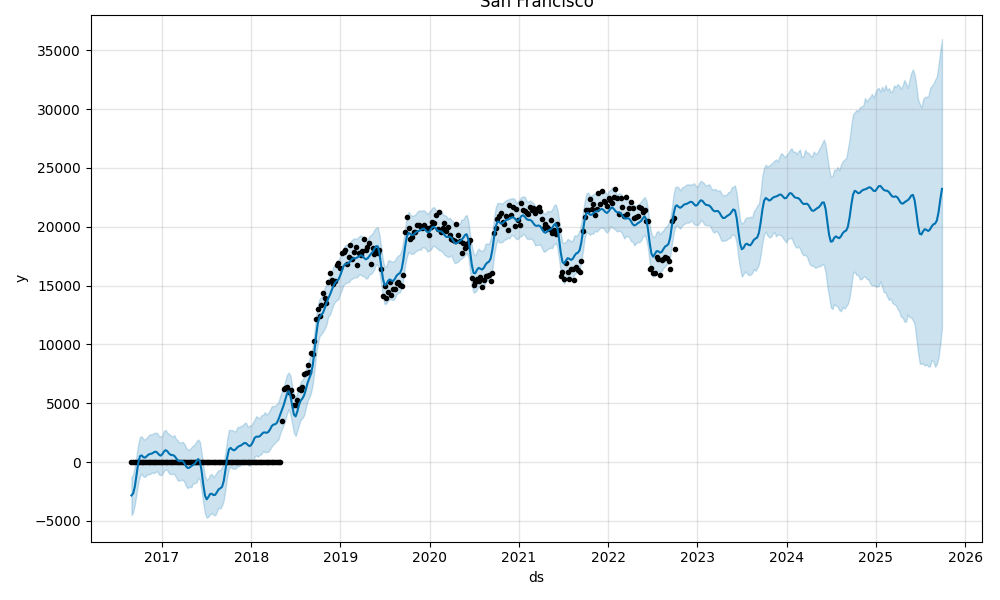

In [37]:
for location in locations:
    models[location].plot(forecasts[location])
    plt.title(location)

Now using the dbt models

In [38]:
models = s.table(f"{schema}.forecast_train_py").to_pandas()
models.tail()

,trained_at,location,model
50,1665318178808607,Brooklyn,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
51,1665318178808607,Chicago,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
52,1665318178808607,New Orleans,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
53,1665318178808607,Philadelphia,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
54,1665318178808607,San Francisco,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."


In [39]:
locations = sorted(list(models["location"].unique()))
locations

['Brooklyn', 'Chicago', 'New Orleans', 'Philadelphia', 'San Francisco']

In [40]:
most_recent_trained_at = models["trained_at"].max()
most_recent_trained_at

1665318178808607

In [41]:
models = models[models["trained_at"] == most_recent_trained_at]
models

,trained_at,location,model
50,1665318178808607,Brooklyn,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
51,1665318178808607,Chicago,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
52,1665318178808607,New Orleans,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
53,1665318178808607,Philadelphia,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."
54,1665318178808607,San Francisco,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp..."


In [42]:
models = {
    location: model_from_json(models[models["location"] == location]["model"].iloc[0])
    for location in locations
}
models

{'Brooklyn': <prophet.forecaster.Prophet at 0x7f0f3816afa0>,
 'Chicago': <prophet.forecaster.Prophet at 0x7f0f3816af70>,
 'New Orleans': <prophet.forecaster.Prophet at 0x7f0f5b9b2910>,
 'Philadelphia': <prophet.forecaster.Prophet at 0x7f0f5b9af430>,
 'San Francisco': <prophet.forecaster.Prophet at 0x7f0f5b859880>}

In [43]:
forecasts = s.table(f"{schema}.forecast_score_py").to_pandas()
forecasts.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,location
2370,1756598400000000,22345.991173,8163.176824,32865.640830,10139.710463,35005.428202,-2065.696445,-2065.696445,-2065.696445,-2065.696445,-2065.696445,-2065.696445,0.0,0.0,0.0,20280.294729,San Francisco
2371,1757203200000000,22357.818751,7998.131607,33354.047313,9983.430334,35196.948852,-1826.043326,-1826.043326,-1826.043326,-1826.043326,-1826.043326,-1826.043326,0.0,0.0,0.0,20531.775425,San Francisco
2372,1757808000000000,22369.646329,8735.398407,34243.857588,9845.043806,35334.698962,-1128.095030,-1128.095030,-1128.095030,-1128.095030,-1128.095030,-1128.095030,0.0,0.0,0.0,21241.551299,San Francisco
2373,1758412800000000,22381.473907,9467.452348,35536.930028,9718.062900,35475.802907,-87.275199,-87.275199,-87.275199,-87.275199,-87.275199,-87.275199,0.0,0.0,0.0,22294.198708,San Francisco
2374,1759017600000000,22393.301485,10399.668555,36465.088605,9619.408979,35643.210360,834.672738,834.672738,834.672738,834.672738,834.672738,834.672738,0.0,0.0,0.0,23227.974223,San Francisco


In [44]:
# hack -- datetime in Snowpark/Pandas funkiness
forecasts["ds"] /= 1e6
forecasts["ds"] = pd.to_datetime(forecasts["ds"], unit="s")
forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          2375 non-null   datetime64[ns]
 1   trend                       2375 non-null   float64       
 2   yhat_lower                  2375 non-null   float64       
 3   yhat_upper                  2375 non-null   float64       
 4   trend_lower                 2375 non-null   float64       
 5   trend_upper                 2375 non-null   float64       
 6   additive_terms              2375 non-null   float64       
 7   additive_terms_lower        2375 non-null   float64       
 8   additive_terms_upper        2375 non-null   float64       
 9   yearly                      2375 non-null   float64       
 10  yearly_lower                2375 non-null   float64       
 11  yearly_upper                2375 non-null   float64     

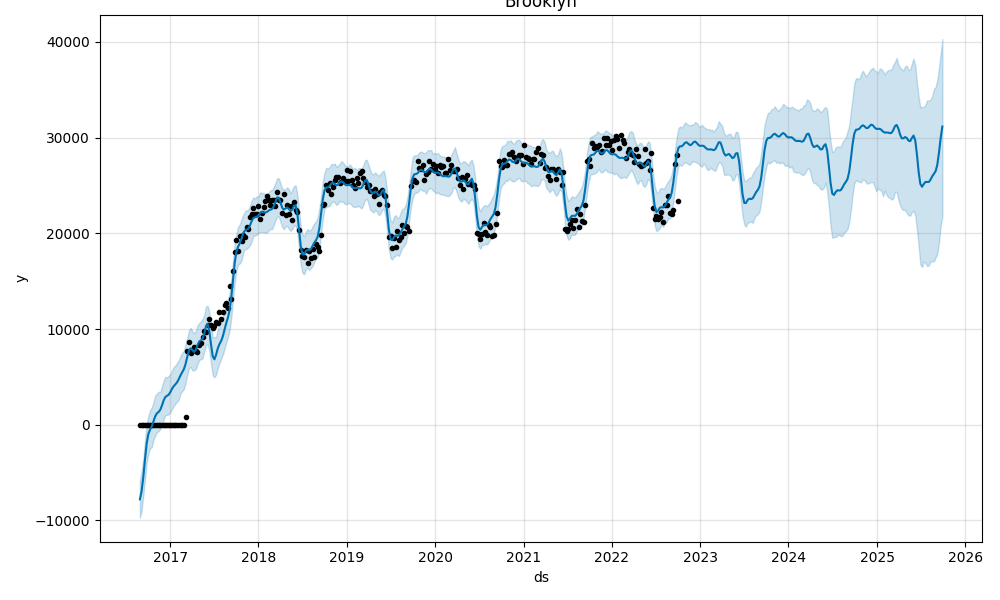

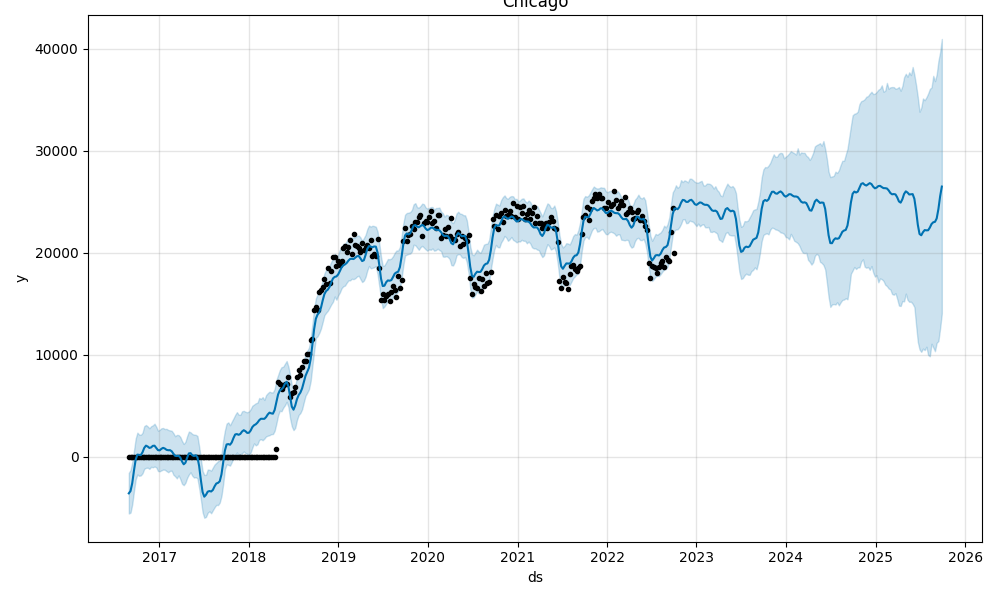

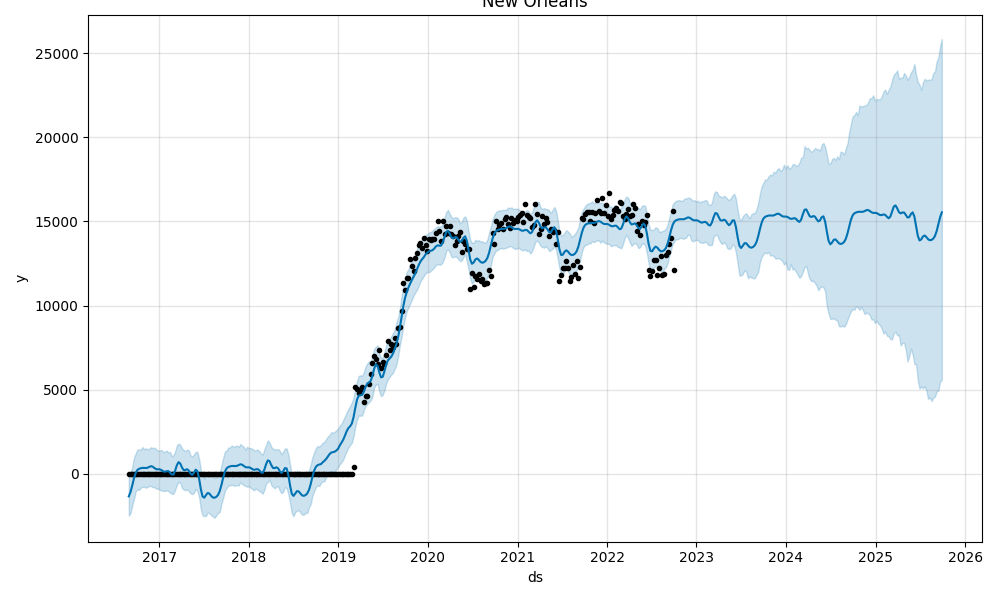

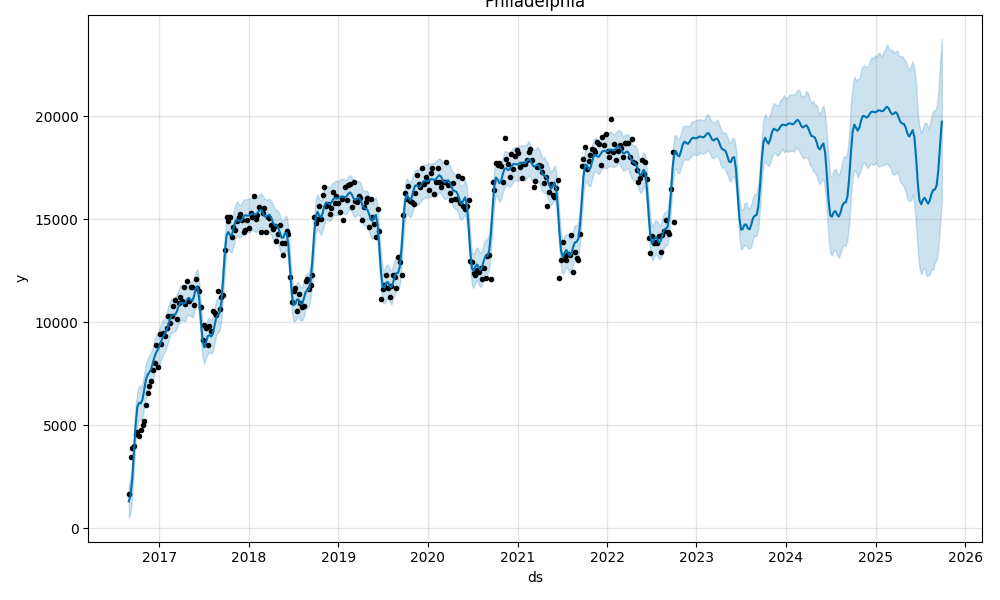

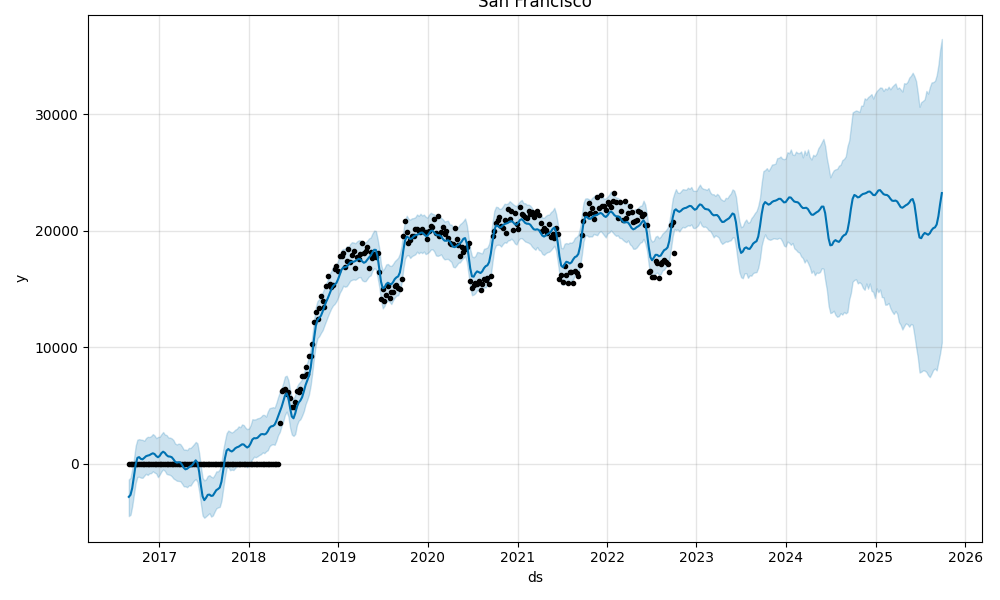

In [45]:
for location in locations:
    models[location].plot(forecasts[forecasts["location"] == location])
    plt.title(location)